In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from efn_util import drawEtas
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, plotContourTruncatedNormal
import seaborn as sns
import tensorflow as tf
from efn_util import drawPoissonCounts, prp_tn_eta
from plot_utils import exptrend, sattrend

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'prp_tn';
D = 2;
K = 100;
M = 1000;
flow_id = '1L_10P';
L = 6;
rs = 0;

In [2]:

savedir = '/Users/sbittner/Documents/efn/results/Fig5/Fig4_prp_tn/EFN_%s_stochasticEta_giveInv_D=%d_K=%d_M=%d_flow=%s_L=%d_rs=%d/' \
          % (exp_fam, D, K, M, flow_id, L, rs);

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
sess = tf.Session();
new_saver = tf.train.import_meta_graph(savedir + 'model.meta');
new_saver.restore(sess, tf.train.latest_checkpoint(savedir));
Z0 = tf.get_collection('Z0')[0];
X = tf.get_collection('X')[0];
eta = tf.get_collection('eta')[0];
log_p_zs = tf.get_collection('log_p_zs')[0];
param_net_input = tf.get_collection('param_net_input')[0];
Tx_input = tf.get_collection('Tx_input')[0];

INFO:tensorflow:Restoring parameters from /Users/sbittner/Documents/efn/results/Fig5/Fig4_prp_tn/EFN_prp_tn_stochasticEta_giveInv_D=2_K=100_M=1000_flow=1L_10P_L=6_rs=0/model


(100, 8)


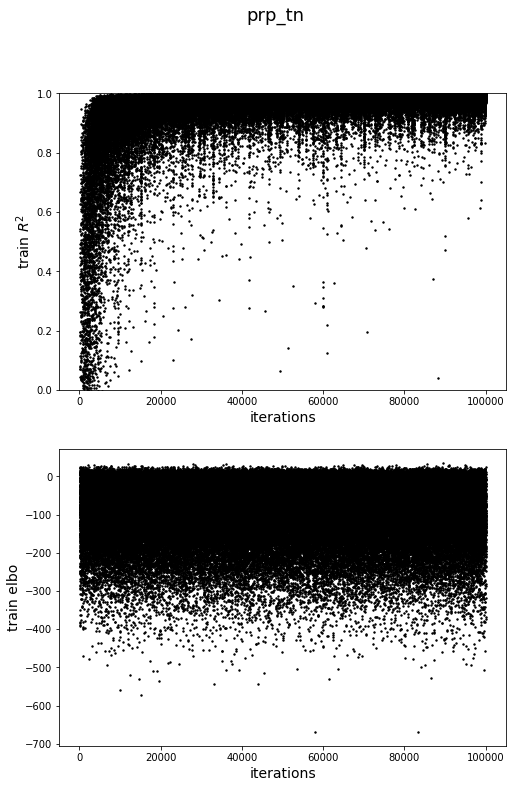

In [3]:
fontsize = 14;
size = 2;

fname = savedir + 'results.npz';
npzfile = np.load(fname);
params = npzfile['params'][()];
_eta = npzfile['eta'];
_param_net_input = npzfile['param_net_input'];
_Tx_input = npzfile['Tx_input'];
print(_eta.shape);
_X = npzfile['X'];
train_elbos = npzfile['train_elbos'];
train_R2s = npzfile['train_R2s'];

check_rate = 100;
N = train_elbos.shape[0];
K_eta = train_R2s.shape[1];
its = check_rate*np.arange(1,N+1, dtype=float);
its = np.tile(np.expand_dims(its, 1), [1,K_eta]);
its_vec = np.reshape(its, (N*K_eta,));
train_elbos_vec = np.reshape(train_elbos[:N,:], (N*K_eta,));
train_R2s_vec = np.reshape(train_R2s[:N,:], (N*K_eta,));

fig = plt.figure(figsize=(8,12));
fig.add_subplot(2,1,1);
plt.scatter(its_vec, train_R2s_vec,size,c='k');
plt.xlabel('iterations', fontsize=fontsize);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train $R^2$', fontsize=fontsize)
plt.ylim([0,1]);
plt.suptitle(exp_fam, fontsize=fontsize+4)

fig.add_subplot(2,1,2);
plt.scatter(its_vec, train_elbos_vec,size,c='k');
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('train elbo', fontsize=fontsize)


In [4]:
print(X);
print(Z0);
print(eta);
print(log_p_zs);
print(param_net_input);

Tensor("Exp_11:0", shape=(100, ?, 2, ?), dtype=float64)
Tensor("Placeholder:0", shape=(?, ?, 2, 1), dtype=float64)
Tensor("Placeholder_1:0", shape=(?, 8), dtype=float64)
Tensor("sub_20:0", shape=(100, ?), dtype=float64)
Tensor("Placeholder_2:0", shape=(?, 11), dtype=float64)


In [5]:
def closest(support_point, Xgrid):
    #constructs an nxn grid and gives back the point on the grid which, after being transformed by the network
    #is closest to simplex_point
    n = Xgrid.shape[0];
    clos = np.array([[Xgrid[0,:]]])
    clos_ind = 0;
    dist = np.linalg.norm(support_point-clos);
    for i in range(n):
        aux_clos = np.array([[Xgrid[i,:]]])
        aux_dist = np.linalg.norm(support_point-aux_clos);
        if aux_dist<dist:
            clos_ind = i;
            dist = aux_dist
    return clos_ind;


def gen_grid(sess, n, X, Z0, log_p_zs, eta, _eta, param_net_input, _param_net_input):
    K = _eta.shape[0];
    M = n*n;
    x = np.linspace(-3.5,3.5,n)
    _z0 = np.zeros((M,2));
    for i in range(n):
        for j in range(n):
            ind = n*i+j;
            _z0[ind,0] = x[i];
            _z0[ind,1] = x[j];
    z0 = np.tile(np.expand_dims(np.expand_dims(_z0, 0), 3), (100, 1, 1, 1));
    feed_dict = {Z0:z0, eta:_eta, param_net_input:_param_net_input};
    Xgrid, log_p_z_grid = sess.run([X, log_p_zs], feed_dict);

    return Xgrid, log_p_z_grid, _z0;

def plotPoissonRatePosterior(Xgrid, log_p_z_grid, xlim, ylim, n_plot):
    x1 = np.linspace(0, xlim, n_plot)
    x2 = np.linspace(0, ylim, n_plot)
    sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.6))
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
    sbpal = sns.color_palette()
    
    Z = np.zeros([n_plot,n_plot])
    for i in range(n_plot):
        for j in range(n_plot):
            support_point = np.array([[x1[i],x2[j]]])
            ind = closest(support_point, Xgrid);
            log_p_z_ij = log_p_z_grid[ind];
            Z[i,j] = log_p_z_ij;
            
    mycm = sns.light_palette("navy", as_cmap=True)
    mycm.set_under('w')
    
    zmin = np.min(Z);
    zmax = np.max(Z);
    nc = 1000.0;
    z_contours = sattrend(zmin, zmax+(1.0/nc)*(zmax-zmin), nc, 6);
    plt.contourf(Z.T, levels=z_contours, cmap=mycm)
    ax = plt.gca();
    #ax.set_xlabel([0,xlim]);
    #ax.set_xticklabels([]);
    #ax.set_ylabel([0,ylim]);
    #ax.set_yticklabels([]);
    return Z;


In [6]:
fontsize = 20;
mus = params['mus'];
Sigmas = params['Sigmas'];
xs = params['xs'];
zs = params['zs'];
Ns = params['Ns'];

new_xs = [];


mu0 = np.array([1, 5]);
Sigma0 = 15*np.array([[1.0, -0.6], [-0.6, 1.0]]);
z0 = np.array([.5, 6]);
N0 = 2;
#x0 = drawPoissonCounts(z0, N0);
x0 = np.array([[0, 3], [1, 0]]);
new_xs.append(x0);

"""
mu0 = np.array([1,1]);
Sigma0 = 5*np.array([[1.0, .8], [.8, 1.0]]);
z0 = np.array([6, 6]);
N0 = 10;
x0 = drawPoissonCounts(z0, N0);
#x0 = np.array([[1, 7], [5, 2]]);
"""

mus[0] = mu0;
Sigmas[0] = Sigma0;
new_xs.append(x0);
zs[0] = z0;
Ns[0] = N0;
eta_0, param_net_input_0 = prp_tn_eta(mu0, Sigma0, x0, N0, True);
_eta[0] = eta_0;
_param_net_input[0] = param_net_input_0;
_Tx_input[0];



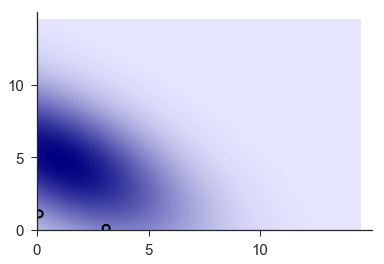

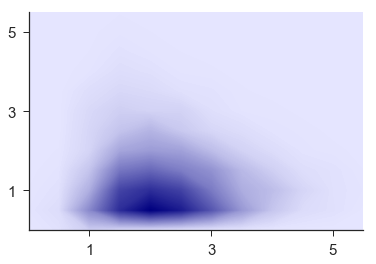

In [11]:
K_show = 1;
n_plot = 30;
xlim = 15;
ylim = 15;
i_start = 0;
for i in range(K_show):
    ind = i+i_start;
    mu_i = mus[ind];
    Sigma_i = Sigmas[ind];
    #x_i = xs[ind];
    x_i = new_xs[ind];
    N_i = int(Ns[ind])
    z_i = zs[ind];
    #plt.subplot(K_show,3,i*K_show+1);
    plt.figure();
    truncnorm = plotContourTruncatedNormal(mu_i, Sigma_i, xlim, ylim, n_plot, scatter=False);
    xscale = x_i.copy();
    xscale[0] = n_plot*xscale[0]/xlim;
    xscale[1] = n_plot*xscale[1]/ylim;
    plt.scatter(xscale[0]+.2, xscale[1]+.2, linewidth=2, facecolors='none', edgecolors='k');
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([0,10,20]);
    ax.set_xticklabels([0, 5, 10]);
    ax.set_yticks([0,10,20]);
    ax.set_yticklabels([0, 5, 10]);
    plt.xlim([0,n_plot]);
    plt.ylim([0,n_plot]);
    #plt.ylabel('eta (prior and data)', fontsize=fontsize);
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig5/2D_eta.pdf', \
    dpi=300, transparent=True)
    #plt.colorbar();
    #plt.title('TN prior on z', fontsize=fontsize);

    #plt.subplot(K_show,3,i*K_show+2);
    #mycm = sns.light_palette("navy", as_cmap=True)
    #mycm.set_under('w')
    #plot_range = [[0, xlim], [0, ylim]];
    #H, xedges, yedges = np.histogram2d(x_i[0,:N_i], x_i[1,:N_i], bins=8, range=plot_range, normed=True)
    #plt.imshow(H.T, origin='lower', interpolation='none', cmap=mycm);
    #ax = plt.gca()
    #ax.set_xlabel([0,xlim]);
    #ax.set_xticklabels([]);
    #ax.set_ylabel([0,ylim]);
    #ax.set_yticklabels([]);
    #plt.title('x', fontsize=fontsize-4);
    #plt.colorbar();

    #plt.subplot(K_show,3,i*K_show+2);
    plt.figure();
    Xgrid, log_p_z_grid, z0s = gen_grid(sess, n_plot, X, Z0, log_p_zs, eta, _eta, param_net_input, _param_net_input);
    Xgrid = Xgrid[ind,:,:,0];
    log_p_z_grid = log_p_z_grid[ind];
    
    Z = plotPoissonRatePosterior(Xgrid, np.exp(log_p_z_grid), 15, 15, n_plot);
    #plt.colorbar();
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    xticks = np.array([1,3,5]);
    xtickpos = n_plot*xticks/xlim;
    ax.set_xticks(xtickpos);
    ax.set_xticklabels(xticks);
    yticks = np.array([1,3,5]);
    ytickpos = n_plot*yticks/ylim;
    ax.set_yticks(ytickpos);
    ax.set_yticklabels(yticks);
    #plt.ylabel('posterior', fontsize=fontsize);
    plt.xlim([xtickpos[0]-1*n_plot/xlim, xtickpos[-1]+1]);
    plt.ylim([ytickpos[0]-1*n_plot/xlim, ytickpos[-1]+1]);
    plt.savefig('/Users/sbittner/Documents/efn/written/figs/fig5/2D_posterior.pdf', \
                dpi=300, transparent=True)
plt.show();